<a href="https://colab.research.google.com/github/dcpatton/Image-Classification/blob/master/malaria_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import random

seed = 52
tf.random.set_seed(seed)
random.seed(seed)

print('TensorFlow version: ' + tf.__version__)

# The Data

In [2]:
raw_ds = tfds.load('malaria', split='train', shuffle_files=True, as_supervised=True, try_gcs=True)

In [3]:
train_ds = raw_ds.take(22046)
test_ds = raw_ds.skip(22046)
val_ds = test_ds.take(2756)
test_ds = test_ds.skip(2756)

In [4]:
def resize_image(image, label):
  image = tf.image.resize(image, [380, 380]) #  This aligns with EfficientNet B4
  return image, label

In [5]:
BATCH_SIZE = 32

train_ds = train_ds.shuffle(1024)
train_ds = train_ds.map(resize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(resize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(resize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

# The Model

In [6]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GaussianNoise
from tensorflow.keras import Input, Model
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, Rescaling, Resizing, RandomFlip, RandomContrast, RandomZoom

model_url = "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1"
hub_layer = hub.KerasLayer(model_url, trainable=False)

inp = Input(shape=(380, 380, 3))
# x = Resizing(380, 380)(inp)
# x = RandomRotation(0.5)(x)
# x = RandomFlip(mode='horizontal_and_vertical')(x)
# x = RandomContrast(0.1)(x)
# x = RandomZoom(height_factor=0.1, width_factor=0.1)(x)
x = Rescaling(scale=1./255., offset=0.0)(inp)
# x = GaussianNoise(stddev=0.2)(x)
x = hub_layer(x)
# x = Dropout(0.25)(x)
# x = BatchNormalization()(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[inp], outputs=[out])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 380, 380, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 380, 380, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 1)                 1793      
Total params: 17,675,609
Trainable params: 1,793
Non-trainable params: 17,673,816
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# Training

In [8]:
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

history = model.fit(train_ds, epochs=200, validation_data=val_ds, callbacks=[es])

Epoch 1/200
689/689 [==============================] - 200s 290ms/step - loss: 0.2404 - auc: 0.9681 - val_loss: 0.1858 - val_auc: 0.9800
Epoch 2/200
689/689 [==============================] - 197s 286ms/step - loss: 0.1689 - auc: 0.9825 - val_loss: 0.1640 - val_auc: 0.9836
Epoch 3/200
689/689 [==============================] - 198s 287ms/step - loss: 0.1541 - auc: 0.9849 - val_loss: 0.1577 - val_auc: 0.9854
Epoch 4/200
689/689 [==============================] - 198s 287ms/step - loss: 0.1457 - auc: 0.9863 - val_loss: 0.1475 - val_auc: 0.9866
Epoch 5/200
689/689 [==============================] - 197s 286ms/step - loss: 0.1408 - auc: 0.9870 - val_loss: 0.1441 - val_auc: 0.9871
Epoch 6/200
689/689 [==============================] - 198s 287ms/step - loss: 0.1362 - auc: 0.9879 - val_loss: 0.1478 - val_auc: 0.9874
Epoch 7/200
689/689 [==============================] - 198s 288ms/step - loss: 0.1336 - auc: 0.9883 - val_loss: 0.1393 - val_auc: 0.9877
Epoch 8/200
689/689 [====================

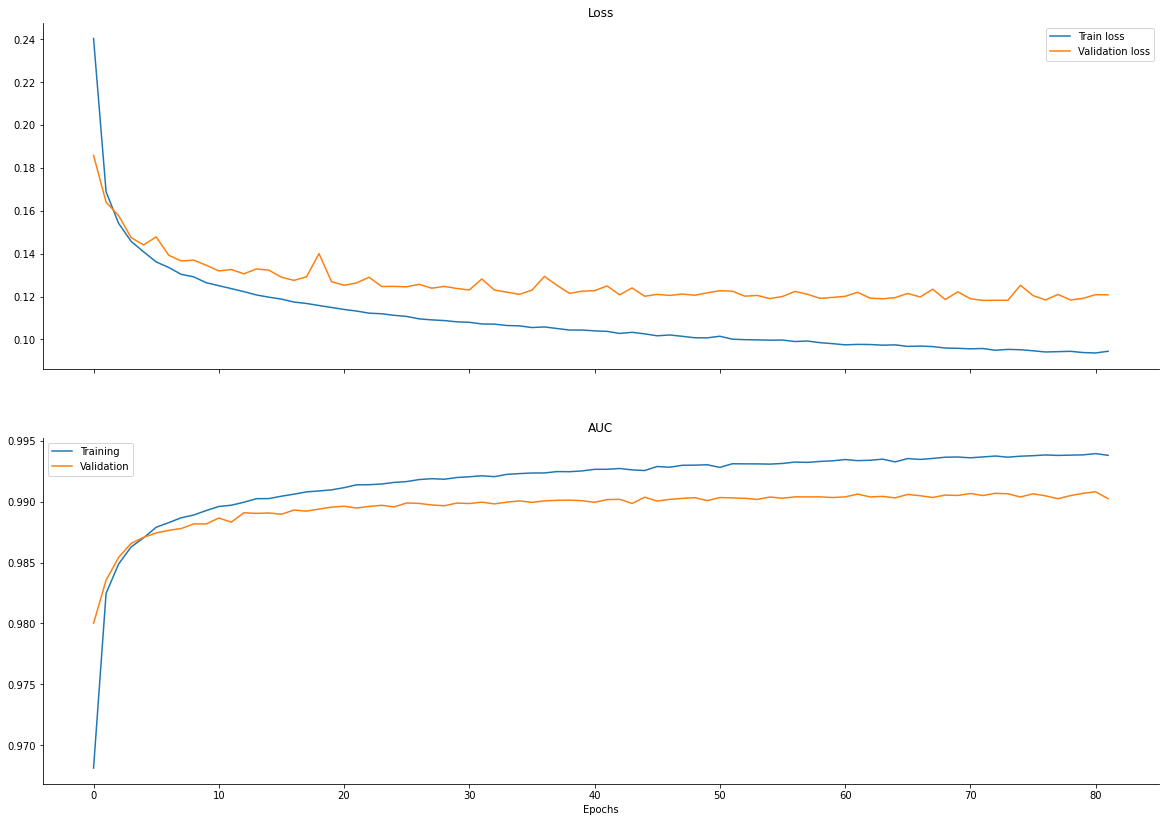

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auc'], label='Training')
ax2.plot(history['val_auc'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('AUC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Evaluation

In [10]:
model.evaluate(test_ds, verbose=1)

87/87 [==============================] - 20s 232ms/step - loss: 0.1306 - auc: 0.9875


[0.13058173656463623, 0.9874762296676636]